# Basic spectroscopy mode observations with MICADO


# !!! Not ready. Revamp for MICADO Sci once it has been checked again

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
import scopesim_templates as sim_tp

As always, we must make sure we have the 3 instrument packages needed for SCAO osbservations. If we need to download the instrument packages, we can use the ``simcopesim.download_package()`` function:
```
sim.download_packages([
    "Armazones",
    "ELT",
    "MICADO",
])
```

### Set up the Source 

For this basic example we will use the helper function ``spiral_two_component`` from the ``scopesim_templates.extragalactic.galaxies`` submodule.
This function creates a ``Source`` object with two intensity maps and two spectra. 
The two maps represent the distribution of the old (top) and new (bottom) stellar populations in the galaxy.
The associated spectra are taken from the Brown et al (2014) galaxy spectra catalogue and are for an elliptical and a starburst galaxy.

For the purpose of illustrating how the spectroscopy mode works, this approximation will be sufficient.

Here we have selected to scale the galaxy images to 16 arcsec on a side and re-scale the spectra such that a pixel value of 1 corresponds to 15 magnitudes arcsec-2 in the AB system.

As the centre of the galaxy is not exactly in the centre of the iamge, we need to shift the ``Source`` 0.12 arcsec downwards so that the slit catched the galactic bulge

In [2]:
gal = sim_tp.extragalactic.galaxies.spiral_two_component(extent=16*u.arcsec, fluxes=(15, 15)*u.mag)
gal.shift(dy=-30*0.004)

https://www.univie.ac.at/simcado/scopesim_templates/spiral_two_component.fits


On the left we have the two intensity maps.
On the right the spectrum associated with these maps.

The vertical line shows were we will set the wavelength that we will centre the observation around

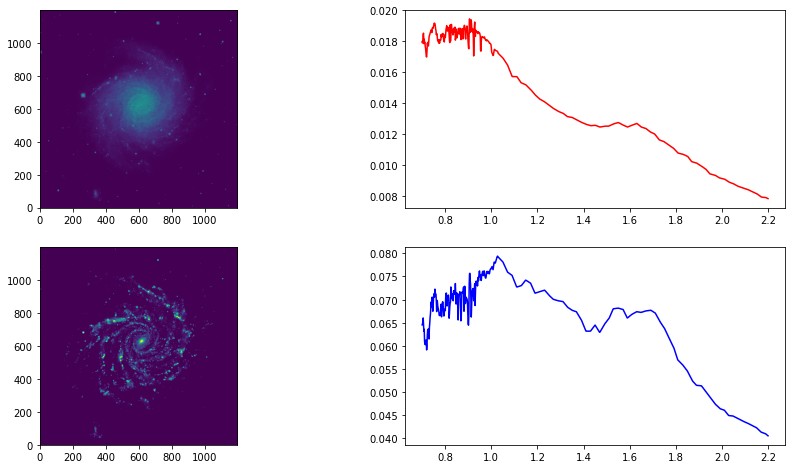

In [3]:
wave = np.linspace(0.7, 2.2, 1001) * u.um

plt.figure(figsize=(15,8))
for i, c in zip([0, 1], "rb"):
    plt.subplot(2,2,2*i+1)
    plt.imshow(gal.fields[i].data, origin="lower")
    plt.subplot(2,2,2*i+2)
    plt.plot(wave, gal.spectra[i](wave), c=c)

We can visualise approximately what portion of the galaxy that we want to come through the slit.

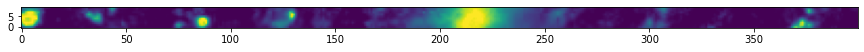

In [4]:
plt.figure(figsize=(15,3))
plt.imshow(gal.fields[1].data[625:635, 400:800], origin="lower")

# Set up MICADO in SPEC mode

Now we follow the standard proceedure to set up the ``MICADO`` optical system using a ``UserCommands`` object.
Before we initialise the optical model, we need to set a few parameters.

- ``!DET.height``: [pixel] in this context will given the number of spectral bins. As the spectral resolution changes with wavelength, it doesn't make sense to specify a desired wavelength region. Instead the user can choose more or fewer spectral bins on the detector. For the sake of speed we will restrict this simulation to 1000 spectral bins.
- ``!OBS.filter_name_fw1``: MICADO has two filter wheels. To view which filters are on which wheels, use ``micado["filter_wheel_2"].filters``
- ``!OBS.dit``: [s] the exposure time

In [5]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "SPEC_15000x50"])
cmd["!DET.height"] = 1000
cmd["!OBS.filter_name_fw1"] = "Spec_HK"
cmd["!OBS.filter_name_fw2"] = "open"
cmd["!OBS.dit"] = 3600
cmd["!INST.psf.strehl"]= 0.2

In the ``MICADO`` package the slit aperture size and position can be set freely. 
The default values correspond to the short-fat slit (3000x50mas) centred on the field of view apnning the x-axis.

In [6]:
cmd["!INST.aperture.x"] = 0             # [arcsec]
cmd["!INST.aperture.y"] = 0
cmd["!INST.aperture.width"] = 3         # [arcsec]
cmd["!INST.aperture.height"] = 0.05    

As always, the standard process for creating an optical model, observing, and reading out the detector window:

In [7]:
micado = sim.OpticalTrain(cmd)
micado.observe(gal)
hdus = micado.readout()

INFO - emission not found in either '.meta' or '.table': [ELT]
INFO - emission not found in either '.meta' or '.table': [I00_EntrWin]
INFO - emission not found in either '.meta' or '.table': [I09_SCAO_PO]
INFO - emission not found in either '.meta' or '.table': [I01_Fold1]
INFO - emissivity not found in either '.meta' or '.table': [I01_Fold1]
INFO - transmission not found in either '.meta' or '.table': [I01_Fold1]
INFO - emission not found in either '.meta' or '.table': [I02_Coli1]
INFO - emissivity not found in either '.meta' or '.table': [I02_Coli1]
INFO - transmission not found in either '.meta' or '.table': [I02_Coli1]
INFO - emission not found in either '.meta' or '.table': [I03_Coli2]
INFO - emissivity not found in either '.meta' or '.table': [I03_Coli2]
INFO - transmission not found in either '.meta' or '.table': [I03_Coli2]
INFO - emission not found in either '.meta' or '.table': [I04_Coli3]
INFO - emissivity not found in either '.meta' or '.table': [I04_Coli3]
INFO - transmiss

INFO - Waverange does not overlap with Spectrum waveset: [14459.999999999996, 14499.999999999996] <> [ 7000.          7050.          7070.52282746  7100.
  7150.          7169.90922239  7200.          7250.
  7270.69263643  7300.          7350.          7372.89270669
  7400.          7450.          7476.52934633  7500.
  7550.          7581.62274839  7600.          7650.
  7688.19338978  7700.          7750.          7796.26203522
  7800.          7850.          7900.          7905.84974132
  7950.          8000.          8016.97786067  8050.
  8100.          8129.668046    8150.          8200.
  8243.9422544   8250.          8300.          8350.
  8359.82275159  8400.          8450.          8477.33211629
  8500.          8550.          8596.49324457  8600.
  8650.          8700.          8717.32935435  8750.
  8800.          8839.86398992  8850.          8900.
  8950.          8964.1210265   9000.          9050.
  9090.12467493  9100.          9150.          9200.
  9217.89948634  92

INFO - Waverange does not overlap with Spectrum waveset: [14459.999999999996, 14499.999999999996] <> [ 7000.          7057.77705817  7085.38850061  7165.69172596
  7185.16584771  7275.25642823  7286.34827217  7386.4963943
  7388.95556048  7493.00777774  7499.43723926  7598.52527164
  7614.10496985  7705.52867638  7730.52599046  7814.03891675
  7848.7271092   7924.07721221  7968.73554409  8035.66508101
  8090.57892931  8148.82434446  8214.28532159  8263.57713113
  8339.88320663  8379.94588121  8467.40150569  8497.95335092
  8596.86958225  8617.62261692  8728.31724875  8738.97708082
  8861.77477348  8862.0404738   8986.83686122  8997.27288752
  9113.39064734  9134.84279184  9241.72658005  9274.5161645
  9371.86975579  9416.32516789  9503.84562437  9560.30245619
  9600.          9610.          9637.67999401  9706.48118286
  9773.39903636  9854.89500829  9911.02929163 10005.57810754
 10050.59767375 10158.5651782  10192.13147568 10313.8914484
 10335.65837471 10471.59268494 10481.2064379  10

INFO - Waverange does not overlap with Spectrum waveset: [14459.999999999996, 14499.999999999996] <> [ 7000.          7057.77705817  7165.69172596  7275.25642823
  7386.4963943   7499.43723926  7614.10496985  7730.52599046
  7848.7271092   7968.73554409  8090.57892931  8214.28532159
  8339.88320663  8467.40150569  8596.86958225  8728.31724875
  8861.77477348  8997.27288752  9134.84279184  9274.5161645
  9416.32516789  9560.30245619  9706.48118286  9854.89500829
 10005.57810754 10158.5651782  10313.8914484  10471.59268494
 10631.70520145 10794.26586686 10959.31211377 11126.88194719
 11297.01395319 11469.74730786 11645.12178627 11823.17777169
 12003.95626482 12187.49889329 12373.84792123 12563.04625899
 12755.13747302 12950.16579591 13148.17613658 13349.21409061
 13553.32595075 13760.55871758 13970.9601103  14184.57857778
 14401.46330966 14621.6642477  14845.23209729 15072.21833911
 15302.67524097 15536.6558699  15774.2141043  16015.4046464
 16260.28303483 16508.90565741 16761.32976416 1

INFO - Waverange does not overlap with Spectrum waveset: [14459.999999999996, 14499.999999999996] <> [ 7000.          7070.52282746  7169.90922239  7180.
  7270.69263643  7372.89270669  7476.52934633  7581.62274839
  7688.19338978  7796.26203522  7830.          7905.84974132
  8016.97786067  8129.668046    8243.9422544   8359.82275159
  8390.          8477.33211629  8596.49324457  8717.32935435
  8839.86398992  8964.1210265   8980.          9090.12467493
  9217.89948634  9347.470357    9478.86253311  9490.
  9612.10161573  9747.2135658   9884.22470919 10000.
 10023.16174178 10164.05173473 10306.92213971 10451.80079427
 10580.         10598.71592725 10747.6961643  10898.77053343
 11051.96847068 11207.31982587 11360.         11364.8548684
 11524.60429313 11686.59922641 11850.8712321  11990.
 12017.45231772 12186.37494073 12357.67201482 12531.37691631
 12707.52349071 12880.         12886.14605922 13067.27942554
 13250.95888254 13437.22021919 13626.09972755 13817.63420978
 13830.         1

The figure below shows the detector window readout in spectroscopy mode.
It's clear that the spectrum from the new population dominates.
It is now up to the user to decide which regions of the spectrum need to be extracted for analysis.
Below we show a very rudimentary way to extract 1D spectra from the image.

Text(0.5, 0, 'Slit position')

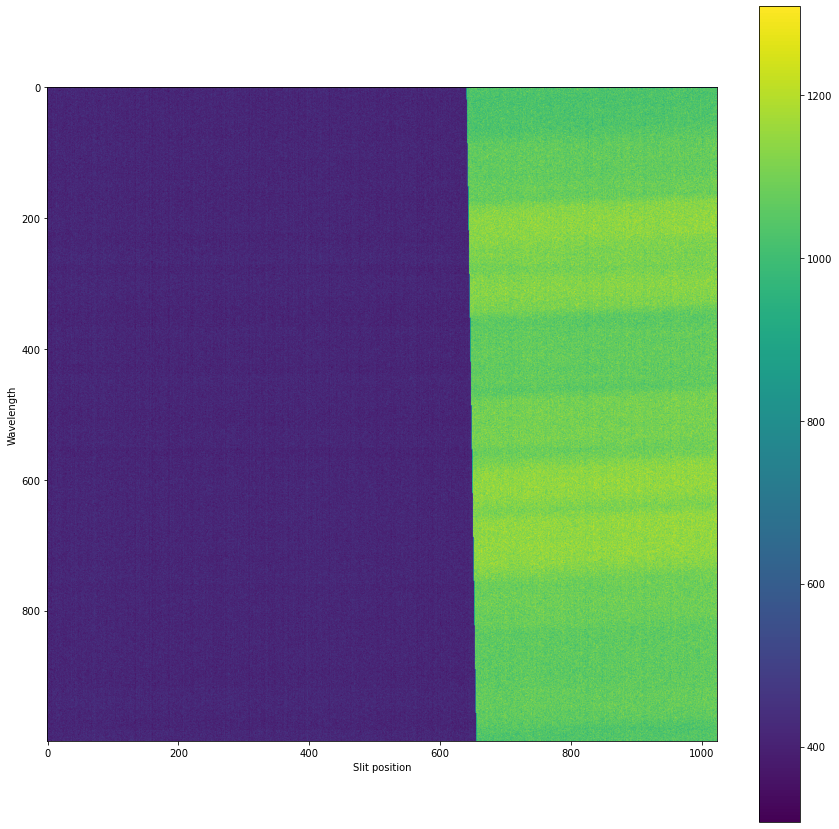

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(hdus[0][1].data)
plt.colorbar()
plt.ylabel("Wavelength")
plt.xlabel("Slit position")

The above image doesn't tell us anything about the wavelength range we're covering, just as the raw MICADO detector readouts will not tell us anything about the observed spectrum. 

We can however extract the wavelength calibration from the MICADO ``OpticalTrain`` object by looking at how many spectral slices (FOV objects) were generated. This requires a bit Python Kung-Fu. Rest assured that this will be easier in later releases of ScopeSim.

In [9]:
# TODO: This does not work currently.
if False:
    waves = [fov.wavelength.value for fov in micado.fov_manager._fovs_list]
    flux = hdus[0][1].data[10:, 400:410].sum(axis=1)

    plt.figure(figsize=(15, 5))
    plt.plot(waves[9:], flux)